Training GCN...
Epoch 1, Train Loss: 2.7847, Val Loss: 2.1080
Epoch 2, Train Loss: 2.1230, Val Loss: 1.6149
Epoch 3, Train Loss: 1.6298, Val Loss: 1.2829
Epoch 4, Train Loss: 1.2964, Val Loss: 1.0614
Epoch 5, Train Loss: 1.0714, Val Loss: 0.9078
Epoch 6, Train Loss: 0.9126, Val Loss: 0.7953
Epoch 7, Train Loss: 0.7954, Val Loss: 0.7095
Epoch 8, Train Loss: 0.7054, Val Loss: 0.6422
Epoch 9, Train Loss: 0.6347, Val Loss: 0.5886
Epoch 10, Train Loss: 0.5782, Val Loss: 0.5455
Epoch 11, Train Loss: 0.5328, Val Loss: 0.5108
Epoch 12, Train Loss: 0.4962, Val Loss: 0.4827
Epoch 13, Train Loss: 0.4663, Val Loss: 0.4595
Epoch 14, Train Loss: 0.4416, Val Loss: 0.4401
Epoch 15, Train Loss: 0.4207, Val Loss: 0.4233
Epoch 16, Train Loss: 0.4027, Val Loss: 0.4085
Epoch 17, Train Loss: 0.3868, Val Loss: 0.3952
Epoch 18, Train Loss: 0.3725, Val Loss: 0.3831
Epoch 19, Train Loss: 0.3595, Val Loss: 0.3719
Epoch 20, Train Loss: 0.3475, Val Loss: 0.3616
Epoch 21, Train Loss: 0.3365, Val Loss: 0.3521
Epoch 

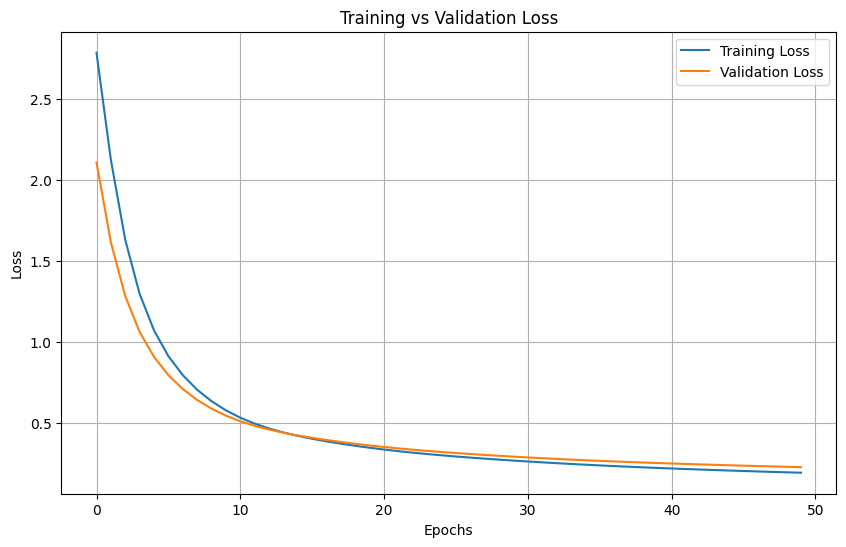

Evaluating Clustering...
NMI: 0.8474, ARI: 0.8628, ACC: 0.9348
Saving Cluster Visualization...


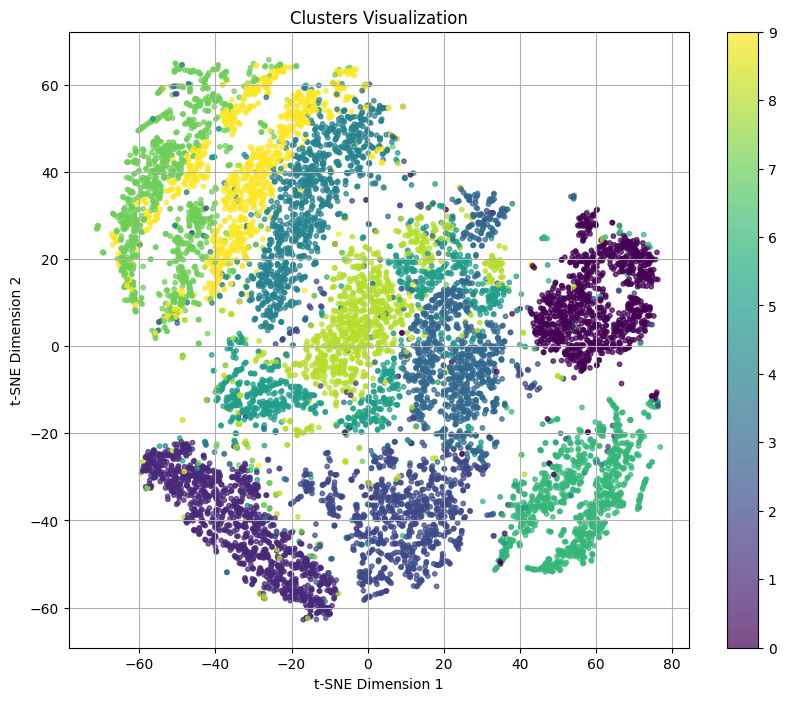

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score, accuracy_score
from sklearn.manifold import TSNE

def load_mnist_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train.reshape(-1, 28 * 28).astype("float32") / 255.0
    x_test = x_test.reshape(-1, 28 * 28).astype("float32") / 255.0
    return x_train, y_train, x_test, y_test

def normalize_data(features):
    scaler = StandardScaler()
    return scaler.fit_transform(features)

def calculate_metrics(y_true, y_pred):
    nmi = normalized_mutual_info_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    return nmi, ari, acc

#model
class GCN(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.fc1 = tf.keras.layers.Dense(hidden_dim, activation='relu')
        self.fc2 = tf.keras.layers.Dense(output_dim)

    def call(self, x):
        x = self.fc1(x)
        return self.fc2(x)

#train
def train_gcn(features_train, labels_train, features_val, labels_val, input_dim, hidden_dim, output_dim, epochs=50, learning_rate=0.001):
    model = GCN(input_dim, hidden_dim, output_dim)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    history = {"train_loss": [], "val_loss": []}

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            logits = model(features_train, training=True)
            train_loss = loss_fn(labels_train, logits)
        grads = tape.gradient(train_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        val_logits = model(features_val, training=False)
        val_loss = loss_fn(labels_val, val_logits)

        history["train_loss"].append(train_loss.numpy())
        history["val_loss"].append(val_loss.numpy())

        print(f"Epoch {epoch+1}, Train Loss: {train_loss.numpy():.4f}, Val Loss: {val_loss.numpy():.4f}")
    
    return model, history

def plot_loss(history, save_path="training_validation_loss.png"):
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')  # Save the plot
    plt.show()

def plot_clusters(features, labels, save_path="clusters_visualization.png", title="Clusters Visualization"):
    tsne = TSNE(n_components=2, random_state=42, perplexity=50)
    reduced_features = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_features[:, 0], 
        reduced_features[:, 1],  
        c=labels,                
        cmap="viridis",          
        s=10,                    
        alpha=0.7                
    )
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.grid(True)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')  
    plt.show()

def main():
    x_train, y_train, x_test, y_test = load_mnist_data()
    x_train = normalize_data(x_train)
    x_test = normalize_data(x_test)
    input_dim = x_train.shape[1]
    hidden_dim = 256
    output_dim = 10

    print("Training GCN...")
    model, history = train_gcn(x_train, y_train, x_test, y_test, input_dim, hidden_dim, output_dim)

    print("Saving Training and Validation Loss Plot...")
    plot_loss(history, save_path="training_validation_loss.png")

    print("Evaluating Clustering...")
    logits = model(x_test, training=False)
    y_pred = np.argmax(logits.numpy(), axis=1)
    nmi, ari, acc = calculate_metrics(y_test, y_pred)
    print(f"NMI: {nmi:.4f}, ARI: {ari:.4f}, ACC: {acc:.4f}")

    print("Saving Cluster Visualization...")
    plot_clusters(x_test, y_pred, save_path="clusters_visualization.png")

if __name__ == "__main__":
    main()
